<a target="_blank" href="https://colab.research.google.com/github/ArtificialIntelligenceToolkit/aitk/blob/master/notebooks/GenerativeAI/ImageGeneration.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding Image Generation
AI Image generation has become increasingly popular with the advent of ChatGPT 4, DALL-E, and Stable Diffusion. Users can create images based on essentially any prompt they choose. This tool, of course, comes with its positives: people can create images that may have not otherwise been able to due to  physical or artistic limitations. However, these systems tend to encode biases, and some researchers suggest it may even exacerbate societal prejudice. In order to have a better understanding of how these tools work, we will provide a high level overview of the process of image generation.

This notebook will focus specifically on the latent diffusion models (LDMs). While nearly all of these image generation systems utilize diffusion, latent diffusion is an infrastructure that has risen to popularity, claiming to be both more stable than other diffusion processes and generating higher quality images.

## Overview of the Image Generation Process
We will provide a high level overview of the process of image generation, emphasizing the goals of this notebook, to understand the importance of noise and embeddings in image generation.

Let's break this process down. Image generation relies on a few concepts that were covered in previous notebooks: embeddings and transformers. Knowledge of these topics is encouraged before continuing on in this notebook, as detail on these topics and their relevance to generative AI will not be reviewed.

**Note:** Before reviewing this notebook, it is suggested that you have at least reviewed our [Word Embedding](https://github.com/ArtificialIntelligenceToolkit/aitk/blob/master/notebooks/GenerativeAI/WordEmbedding.ipynb) notebook. Additionally, if you want to have a more concrete understanding of how large language models work, please review the [NanoGPT](https://github.com/ArtificialIntelligenceToolkit/aitk/blob/54f60f3a0316760d2a9709af04074ec5dc7d2a56/notebooks/GenerativeAI/NanoGPT.ipynb) notebook as well.

## Contrastive Language-Image Pre-training (CLIP)

How could we teach a machine to generate an appropriate picture given a text description?

One part of this process starts with a model called CLIP, which stands for Contrastive Language-Image Pre-training.

CLIP was first introduced in the paper [Learning Transferable Visual Models From Natural Language Supervision](https://arxiv.org/abs/2103.00020) (see reference [6]). The basic idea behind CLIP is to establish a correlation between a particular caption and its associated image. We can see how this may be applicable to a text to image generation system, such as Stable Diffusion or DALL-E. At the time the paper outlining CLIP was written, however, CLIP was simply used as a computer vision tool to recognize or match images to some corresponding text. This embedding technique is now used as a foundational step in image generation.

CLIP is trained using hundreds of millions of image and caption pairs scraped from the internet. In fact, your personal photos and captions shared via social media applications may be part of the data used to train current image generation tools.

In the diagram below, we can see how CLIP is trained. On the left side of the diagram, we see two encoders, one takes in a caption and the other takes in an image. The purple boxes represent a collection of text embeddings and the green boxes represent their associated image embeddings. **The goal of the training process is to move a pair of related embeddings closer together in the embedding space, reflecting that they embody the same concepts.** Thus we want the embeddings of Image1 and Text1 to be the closest together when we compare along row1 or column1. Similarly we want the embeddings of Image2 and Text2 to be closest together when we compare along row2 and column2. This is the contrastive aspect of the CLIP model and is why the diagonal relationships of the matrix are highlighted in blue.

But how are these embeddings relevant to image generation?  In the next subsection we will look at CLIP embeddings' role in latent diffusion models.
<center><img src="images/CLIP.png" width="60%"></center>

## Latent Diffusion Models

An effective tool to understand the process of image generation is a visualization of the process. Below is a diagram of an example of a latent diffusion text-to-image infrastructure (the focus of this notebook).

Source: [Hierarchical Text-Conditional
Image Generation with CLIP Latents](https://arxiv.org/pdf/2204.06125) (see reference [7]).

<center><img src="images/DALLE.png" width="60%"></center>

The top half of this diagram represents the CLIP model that has been pre-trained as described above. This model establishes a connection between text embeddings and image embeddings that represent the same concepts.

The bottom half of the diagram shows how a latent diffusion model can use these pre-trained embeddings to generate new images.

Starting from the left side is the first step in the image generation process when the user enters a prompt. This prompt will then be encoded into a text embedding.

The next step is determining a corresponding image embedding given this text embedding. The text embedding is fed into the prior and the model generates an estimated image embedding for the image it hopes to produce. Finally the image embedding is decoded to produce an actual image. How does this decoding actually work?

### Decoding

The decoder starts with a completely noisy image (as shown below) and pushes it towards the desired outcome using the image embedding generated through the prior as the guide. This is akin to reversing the image embedding process. Instead of taking an image and creating an embedding, it is taking an embedding and creating an image.

<center><img src="images/noise.jpeg" width="45%"></center>

Through this process of denoising and pushing the noisy image towards the desired  embedding, we are able to generate images based on text prompts. For example we can make this completely noisy image become the image on the right of the diagram above of "a corgi playing a flame throwing trumpet"

Feats such as these are achieved in the image generation process, making use of text embeddings, image embeddings, and denoising.

<center><img src="images/cats.png" width="60%"></center>

Above is another example of a visualization of image generation. Working from left to right, the system is given a starting image and gradually adds noise to it. Then working from right to left, the system uses a generative process to reverse this process, denoising the noisy image back to the original, starting image. In the case of LDMs, the generation uses a CLIP image embedding to push the noisy image towards an image that matches the generated CLIP text embedding.

 On a high level, the process we just explained is essentially the process that systems like DALL-E 2, Stable Diffusion, and several other image generation models use, including ChatGPT 4 which relies on DALL-E infrastructure.

Of course, this is a vast simplification of the very detailed and math-driven process of LDMs. If you are interested in learning more about LDMs, please consider reading the paper that first outlined LDMs and is the basis of Stable Diffusion: [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/abs/2112.10752) (see reference [8]). This text is suggested for individuals with extensive background in math and CS. For this notebook, we will take time to describe the process of noising and CLIP in greater detail.

##Playing with Image Generation Processes
In the following sections, we will provide interactive examples for the concepts that we introduced in the previous section.

### Noising
An essential component to image generation is (de)noising operations. As creating a network that emulates the entire image generation process is quite computationally and resource expensive, we will look at a simple example of noising and then denoising an image. In the next section, we will focus on an example of CLIP embeddings.

Here we import the relevant libraries for this notebook to run.

In [ ]:
%pip install aitk --quiet
%pip install transformers --quiet
%pip install pillow --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.7/454.7 kB 9.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.7 MB/s eta 0:00:00


In [ ]:
from aitk.utils import gallery, array_to_image, get_dataset

import numpy as np
import matplotlib.pyplot as plt
import os

from skimage.util import random_noise
from skimage.restoration import denoise_tv_chambolle
from google.colab import drive

import transformers
import urllib.request
import PIL.Image

For this notebook, we will use a simple dataset of flowers, but focus on just 3 of the 100 possible images.

Here we will load in this dataset.

In [ ]:
data = get_dataset("flowers")

1727897600it [00:00, 32101628331.03it/s]


You, the user, can choose between these flowers to perform noising and denoising tasks over the course of this notebook:

<img src="images/flowers.png" width="60%">

Choose the flower you wish to apply noising and denoising to. For example, if you want the first flower, set the variable *flower* equal to 1.

In [ ]:
flower = 1

In [ ]:
#@title run this cell to create assign function
def assign(flower):
  if flower == 1:
    input = data[50]
  elif flower == 2:
    input = data[28]
  elif flower == 3:
    input = data[85]
  return input

Run the assign function to assign your chosen flower!

In [ ]:
input = assign(flower)

This function will allow us to show the images that are created through this noising and denoising process.

In [ ]:
def show_image(image, title='Image', cmap_type = 'gray'):
  plt.imshow(image, cmap = cmap_type)
  plt.title(title)
  plt.axis('off')

Here we are shown what the original image looks like before noise is applied to it.

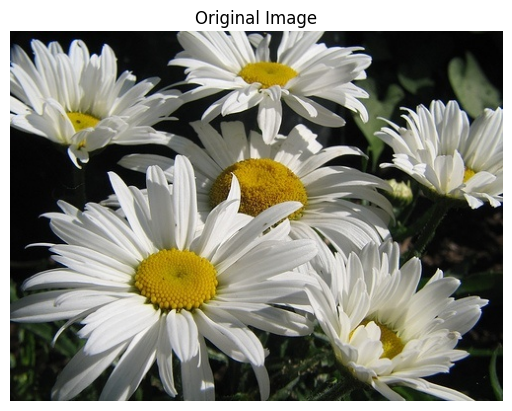

In [ ]:
show_image(input, 'Original Image')

Now, we will make this image noisy, in order to be able to show the process of denoising an image.

Set *total_noise* equal to a decimal in the range of *0.01* to *0.99*. This will specify the total amount of noise you wish to apply to the image:

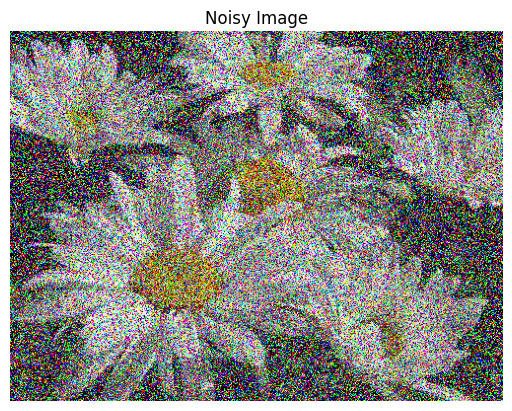

In [ ]:
total_noise = 0.5
noisy_image = random_noise(input, mode = 's&p', clip = True, amount = total_noise)
show_image(noisy_image, 'Noisy Image')

Now, we have a noisy image. In this next subsection, we will focus on denoising the image and reviewing the results of the denoising process.

### Denoising
In this subsection, we will use the image we added noise to in the previous section to demonstrate what a denoising process would look like.

In this code cell, we will denoise the image several times. A gallery of first the input image, then the noisy image, and then each step of denoising, ending with the final denoised image will be outputted.

0,1,2
3,4,5
6,7,

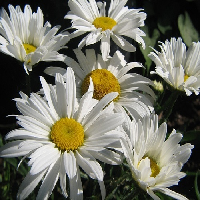
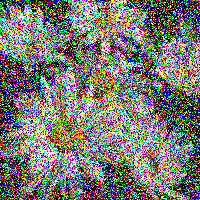
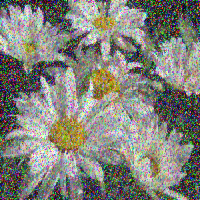
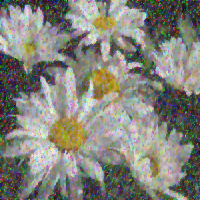
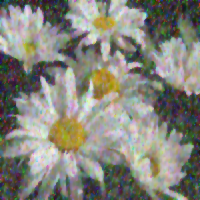
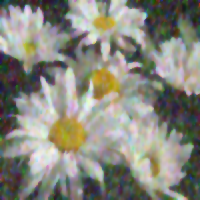
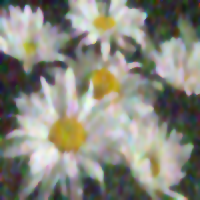
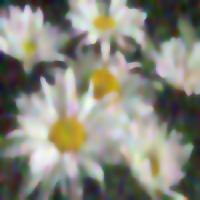

In [ ]:
new_dn = denoise_tv_chambolle(noisy_image, weight = 0.1, channel_axis = -1)
images = []

images.append(input)
images.append(noisy_image)

for i in range(6):
  new_dn =  denoise_tv_chambolle(new_dn, weight = 0.1, channel_axis = -1)
  images.append(new_dn)

images1 = [array_to_image(images[i]) for i in range(len(images))]
small = [image.resize((200,200), resample=0) for image in images1]
gallery(small)

This gallery above displays each of the discrete components of the noising and denoising process. **Let's compare the original image to the noisiest version and the denoised version.**

*write observations here*

Now that you have completed the two (de)noising subsections, go back to the beginning of the noising subsection and change the noise values or images. **Follow the prompts below for changing these parameters.**

**Find which threshold of noising achieves satisfactory denoising results (do not simply enter 0.01 noise level). Try to find a threshold that yields satisfactory results. This may additionally mean testing the noise levels on various images.**

*record results here*

After you complete this process, **reflect on its relevance to image generation**. One of the purposes of this task was to emulate the image generation process of fixing and adjusting noise levels to reach a desirable image outcome.

*write reflections here*

### An Example of CLIP Embeddings
In this subsection, we will provide a brief example of CLIP embeddings on the flowers we used in the denoising section of this notebook. The code for this example drew inspiration from [Understanding OpenAI’s CLIP model](https://medium.com/@paluchasz/understanding-openais-clip-model-6b52bade3fa3) (see reference [5]).

In the previous section, we established that noising and denoising is essential to generating images through LDMs. Through the example we provided, we showed with high levels of noise, the denoising process will struggle to accurately recreate the original image. Keep in mind LDMs' decoders start with a completely noisy image. It does not use a noisy version of the end result as we did in the previous section. As we overviewed in the context section, CLIP image embeddings are generated to give direction to our denoising processes.

In this section, we will show a small example of a task CLIP embeddings can achieve. CLIP image embeddings purpose is to explicitly define an embedding for an image that correlates closely to its corresponding text caption. However, we will be using a model that uses CLIP embeddings to assign an image to a category. This is one application of CLIP embeddings. In image generation, CLIP embeddings are created by the transformer. We are using this simple example to give a quick demonstration of how CLIP can be used to correlate an image and some text.

Flowers from the section above:

<img src="images/flowers.png" width="60%">

Here we are loading the model we will use, using a pre-trained transformer from [Hugging Face](https://huggingface.co/docs/transformers/en/index).

In [ ]:
model = transformers.CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = transformers.CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Enter which flower you want to use for this example:

In [ ]:
flower_choice = 1

In [ ]:
img = assign(flower_choice)

Here we define the possible classes that the image can be assigned as: flower, tree, or shrub. CLIP embeddings perform best when the classes are defined as "an image of *category*", so for the purposes of this notebook that is how we will define our embeddings that we will correspond to an image.

In [ ]:
possible_classes = ["an image of a flower", "an image of a tree", "an image of a shrub"]

This next code block will embed our image and compare it to the embeddings of the possible classes it could belong to. The dot products of these embeddings will allow us to determine which category our image most closely aligns with. The higher the decimal output, the higher the probability that our image is in the corresponding category.

In [ ]:
inputs = processor(text=possible_classes, images = img, return_tensors = "pt", padding = True, truncation = True)
outputs = model(**inputs)
dot_products_per_image = outputs.logits_per_image
dot_products_per_text = outputs.logits_per_text
probabilities = dot_products_per_image.softmax(dim = 1)

Now we will print the probabilities from the embedded dot products.

In [ ]:

print("flower: ", probabilities[0][0])
print("tree: ", probabilities[0][1])
print("shrub: ", probabilities[0][2])

flower:  tensor(0.9826, grad_fn=<SelectBackward0>)
tree:  tensor(0.0002, grad_fn=<SelectBackward0>)
shrub:  tensor(0.0172, grad_fn=<SelectBackward0>)


Test this CLIP embedding example with several different flowers. **How does the categorization change for each of the flowers?** Notice how flower2 tends to be categorized as a shrub. **Why might this be?** *When rerunning the model on different flowers only rerun from the cell where you choose the flower and down.*

*write reflection here*

**Reflect on this process of playing with CLIP embeddings. What did you take away from this exercise?**

*write reflection here*

CLIP embeddings have been trained on hundreds of millions of text, image pairs in order to accurately predict the corresponding text given a specific image and vice versa. This larger dataset is likely to encode societal biases and other prejudices. **What are some potential pitfalls you can foresee with the concept of CLIP embeddings?**

*write reflections here*

## Issues with Image Generation
This process is far from perfect. How do the flaws of denoising potentially reveal themselves in image generation?
Further, what biases does image generation inherit from the datasets it is trained on?

In this section we will overview both flaws present in the results of image generation, as well as biases present in image generation.

### Flaws
Some AI generated images look abnormal. An image of a person could be missing feet, have strange eyes, or may have an extra finger or two. A prompt asking it to generate a single animal, having two animals attached. How does this relate to what we have learned?

In earlier image generation models, flaws in the processes were very explicit (see reference [2]). However, as time has gone on, image generators have become increasingly sophisticated with the advent of improved models. LDMs in particular have ushered in a new era of image generation capabilities, creating high quality images without excessive computational resources. At first glance, images generated by these newer models may seem very good (see image below). However, as you look closer at the image you may notice some issues. These issues are likely a combination of issues with denoising and embedding errors. **What issues do you see with the below image?**

*write reflections here*

The prompt to generate this image was: "a group of students at Swarthmore College in a computer science lab." It was generated on DALL-E 2.

<center><img src="images/gen_image.jpg" width="45%"></center>

Here are a few of the issues we noticed in the image:

<center><img src="images/flaws.png" width="60%"></center>

In both the first and third issue, we see some facial abnormalities, with unnatural facial features, including distorted ears and eyes. Feature abnormalities such as these are fairly common in image generation. In the middle image, we see some unclear writing on the individual's shirt. Image generation is notoriously very bad at generating words in images. This case is particularly unfortunate as it is not clear what this shirt is supposed to say, however, it potentially relates to Swarthmore College, given the prompt and the Garnet shirt coloring--Swarthmore College's colors.

Additionally, notice the demographic composition of this image. Notably, there is only one female presenting individual in the image that contains seven people. In the section below, we will explore why this image might display this bias towards female presenting people in the computer science field.

### Biases
Generative AI is biased. Why do these biases exist and how can we work towards less biased AI systems?

**Note:** If you have not already done so, we suggest you read our [Data Manipulation](https://github.com/ArtificialIntelligenceToolkit/aitk/blob/master/notebooks/DataManipulation.ipynb) notebook for more information about class imbalance and biases in AI's training datasets and their composition.

Generative AI has risen to popularity in recent years and image generation has emerged as one of the most popular aspects of this new technology. With its increasing use, however, its biases and encoded prejudices have come to the forefront. A Youtube video by the London Interdisciplinary School provides a good overview of biases in text-to-image AI systems (see reference [4]). Watch the video below!

[![IMAGE ALT TEXT](https://i.ytimg.com/vi_webp/L2sQRrf1Cd8/maxresdefault.webp)](https://www.youtube.com/watch?v=L2sQRrf1Cd8 "How AI Image Generators Make Bias Worse")

This video overviews the harmful biases and distortion of reality that is perpetuated by AI image generators. There are several important takeaways from this video that we wish to highlight. Firstly, the video introduces the findings of a Bloomberg article, "Humans Are Biased. Generative AI Is Even Worse," that details gender and racial biases in Stable Diffusion's image generation (see reference [2]). The article finds that Stable Diffusion's text-to-image model has racial and gender biases among images generated of people of specific careers that are stronger than reported in the US Bureau of Labor Statistics. Their analysis includes over 5,000 generated images, which they are using as the basis of their conclusions. They found that these models “specifically overrepresented people with darker skin tones in low-paying fields" (see reference [2]). Criminals, more generally, are more likely to be represented as non-white people, reinforcing racist stereotypes. In particular, these systems were found to be extremely orientalist, "When prompted to generate images of a “terrorist,” the model consistently rendered men with dark facial hair, often wearing head coverings — clearly leaning on stereotypes of Muslim men" (see reference [2]). These image generators are not only promoting stereotypes but exacerbating them.

<center><img src="images/jobs.png" width="45%"></center>

The above image partially displays the findings relating to the demographic composition of images generated when a specific occupation was given. The faces are composites created by aligning all the faces generated for each of these searches. Through these examples, it can be seen that white men are more likely to be represented in high paying careers, where women and people of color are more likely to be depicted when the system is prompted to generate individuals in low paying occupations.

Additionally, representational harms are created by these systems. In short, image generation biases can degrade groups and further amplify stereotypes. These stereotypes result in reinforcing individuals' biases as well as other harms, including discouraging minorities from pursuing a specific career due to lack of representation, for example.

Not only does AI generate biased images as a result of datasets on which they are trained, but as these images are generated, they could be fed back into their training sets, creating a feedback loop that intensifies bias. The generator generates a biased image and the biased image is once again used to generate new images. This feedback loop has the potential to create real harms and these problems have largely gone unaddressed. The issue now exists in how these biases should be confronted. The video outlines philosophical questions on fairness and equal representation for the viewer to consider. There is no clear, straightforward answer, although it is obvious something must be done about the harms that AI is perpetuating through its biased image generators.

<center><img src="images/criminal.png" width="45%"></center>

The above image shows the results from the Bloomberg article on skin tone breakdown for results of generating inmates, drug dealers, and terrorists. Police departments are considering using AI for suspect sketching which has raised alarm bells for many aware of bias in these generative systems.



> **"Whether AI will help us reach our aspirations or reinforce the unjust inequalities is ultimately up to us."**
*-Joy Buolamwini* (see reference [3])



**Consider the above quote.** **What are some harms that you find particularly concerning with regard to AI image generators and how would you like to see these harms addressed?** Take into consideration the question of ethics presented in the video. **What ethical principles do you deem appropriate for addressing these issues of bias?**

*write reflections here*

For more regarding navigating biases in AI, please read our [Data Manipulation](https://github.com/ArtificialIntelligenceToolkit/aitk/blob/master/notebooks/DataManipulation.ipynb) notebook, specifically the section titled "Navigating Biases," although it is suggested you read the entire notebook to understand these concepts in greater detail.

## References

[1] A Brief History of AI-Powered Image Generation. 5 Apr. 2023, https://sii.pl/blog/en/a-brief-history-of-ai-powered-image-generation/.

[2] Bloomberg - Are You a Robot? https://www.bloomberg.com/tosv2.html?vid=&uuid=6db7a139-395e-11ef-a8cd-a7229c92a568&url=L2dyYXBoaWNzLzIwMjMtZ2VuZXJhdGl2ZS1haS1iaWFzLw==. Accessed 3 July 2024.

[3] “Joy Buolamwini: Examining Racial and Gender Bias in Facial Analysis Software.” Google Arts & Culture, https://artsandculture.google.com/story/joy-buolamwini-examining-racial-and-gender-bias-in-facial-analysis-software/BQWBaNKAVWQPJg. Accessed 3 July 2024.

[4] LIS - The London Interdisciplinary School. How AI Image Generators Make Bias Worse. 2023. YouTube, https://www.youtube.com/watch?v=L2sQRrf1Cd8&list=TLPQMjAwNjIwMjQ5B-qkdRum6Q&index=3.

[5] Palucha, Szymon. “Understanding OpenAI’s CLIP Model.” Medium, 14 Apr. 2024, https://medium.com/@paluchasz/understanding-openais-clip-model-6b52bade3fa3.

[6] Radford, Alec, et al. Learning Transferable Visual Models From Natural Language Supervision. arXiv:2103.00020, arXiv, 26 Feb. 2021. arXiv.org, https://doi.org/10.48550/arXiv.2103.00020.

[7] Ramesh, Aditya, et al. Hierarchical Text-Conditional Image Generation with CLIP Latents. arXiv:2204.06125, arXiv, 12 Apr. 2022. arXiv.org, https://doi.org/10.48550/arXiv.2204.06125.

[8] Rombach, Robin, et al. High-Resolution Image Synthesis with Latent Diffusion Models. arXiv:2112.10752, arXiv, 13 Apr. 2022. arXiv.org, https://doi.org/10.48550/arXiv.2112.10752.